## Machine Learning Modeling

In [2]:
#import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import re
from numpy.random import normal
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from six import StringIO 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from IPython.display import Image
import pydotplus
import warnings
warnings.filterwarnings('ignore')

flights = pd.read_csv('final_data.csv', index_col=0)

In [3]:
#Preview first 5 rows of the dataste
flights.head()

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,...,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DELAYED
0,705,125,634,810,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1859,189,1028,2208,337,0,0,82,255,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,1735,147,931,2102,-19,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1815,185,1436,2320,-7,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2125,100,481,2305,13,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


### Functions Used for Project

Several functions will be used to automate the process in our notebook. The functions used are printed below.

In [3]:
#write function to train and predict model, then print score results 

def model_fit(smotex, smotey, trainx, trainy, testx, testy, model, name):  
    
    model.fit(smotex, smotey)

    test_prediction = model.predict(testx)
    train_prediction = model.predict(trainx)
    
    result = {'model': name}
    
    result['train_accuracy'] = np.around((accuracy_score(trainy, train_prediction)), decimals=3)
    result['train_precision'] = np.around((precision_score(trainy, train_prediction)), decimals=3)
    result['train_recall'] = np.around((recall_score(trainy, train_prediction)), decimals=3)
    result['train_f1'] = np.around((f1_score(trainy, train_prediction)), decimals=3)
    
    result['test_accuracy'] = np.around((accuracy_score(testy, test_prediction)), decimals=3)
    result['test_precision'] = np.around((precision_score(testy, test_prediction)), decimals=3)
    result['test_recall'] = np.around((recall_score(testy, test_prediction)), decimals=3)
    result['test_f1'] = np.around((f1_score(testy, test_prediction)), decimals=3)
    
    print("\n")
    
    print("Train Score Results")
    print(classification_report(trainy, train_prediction))       
    print("Train Set Accuracy:", result['train_accuracy'])
    print("Train Set Precision:", result['train_precision'])
    print("Train Set Recall:", result['train_recall'])
    print("Train Set F1-Score:", result['train_f1'])

    print("\n")
    
    print("Test Score Results")    
    print(classification_report(testy, test_prediction)) 
                                      
    print("Test Set Accuracy:", result['test_accuracy'])  
    print("Test Set Precision:", result['test_precision']) 
    print("Test Set Recall:", result['test_recall'])
    print("Test Set F1-Score:", result['test_f1'])
                                      
    
    print("\n")
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    trainmatrix = plot_confusion_matrix(model, trainx, trainy, cmap=plt.cm.Blues, ax=ax1)
    testmatrix = plot_confusion_matrix(model, testx, testy, cmap=plt.cm.Blues, ax=ax2)
    ax1.set_title('Train Confusion Matrix')
    ax2.set_title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return result

In [4]:
# function for plotting a feature importance histogram 
def features_plot(df, title):
    df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = df, orient = 'h', color = 'blue') \
       .set_title(title, fontsize = 20)

In [5]:
#Function for creating a feature importance dataframe
def features_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

### Train Test Split

In [5]:
#Explore the class distribution of the target variable 
flights['DELAYED'].value_counts()

0    6384
1    3616
Name: DELAYED, dtype: int64

In [6]:
#Set X and y values 
y = flights['DELAYED']
X = flights.drop(['DELAYED'], axis=1)

In [7]:
#Investigate the value counts of our target variable 
y.value_counts(normalize=True)

0    0.6384
1    0.3616
Name: DELAYED, dtype: float64

In [8]:
#Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We see that there is quite a bit of a class imbalance in our target variable; 63.8% of our flights were not delayed while only 36.2% were delayed. One sampling technique that we can investigate is downsampling the majority class. I will implement this below.

In [11]:
#Create a variable of the majority class where DELAYED=0
df_majority = flights[flights['DELAYED']==0]

#Create a variable of the minority class where DELAYED=1
df_minority = flights[flights['DELAYED']==1]

In [10]:
#Import resampling from sckitlearn
from sklearn.utils import resample

In [12]:
#Downsample majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=0)

In [13]:
#Check length of neew majority downsampled class 
len(df_majority_downsampled)

3616

While this is a useful technique in theory, in practice, it will cause us to lose a lot of valuable information from our majority class. As a result, we will apply a SMOTE technique in order to create synthesized data in order to improve our model. 

In [14]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    6384
1    3616
Name: DELAYED, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    4795
0    4795
Name: DELAYED, dtype: int64


## Section A: Vanilla Models

### 1. KNN

In [11]:
#Scale the data
scaler = StandardScaler()  
scaler.fit(X_train)

#Scale original X_train and X_test
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

#Scale the resampled train 
X_train_resampled_scaled = scaler.transform(X_train_resampled)  

In [12]:
#Fit and predict the vanilla model
knnmodel = KNeighborsClassifier()



Train Score Results
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      4795
           1       0.70      0.76      0.73      2705

    accuracy                           0.79      7500
   macro avg       0.78      0.79      0.78      7500
weighted avg       0.80      0.79      0.80      7500

Train Set Accuracy: 0.795
Train Set Precision: 0.697
Train Set Recall: 0.762
Train Set F1-Score: 0.728


Test Score Results
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1589
           1       0.48      0.51      0.49       911

    accuracy                           0.62      2500
   macro avg       0.59      0.59      0.59      2500
weighted avg       0.62      0.62      0.62      2500

Test Set Accuracy: 0.618
Test Set Precision: 0.478
Test Set Recall: 0.507
Test Set F1-Score: 0.492




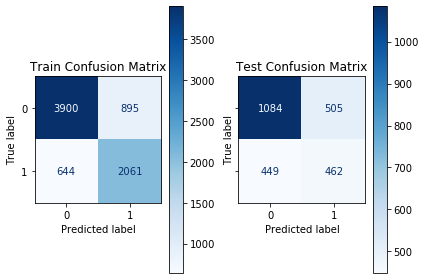

In [13]:
#Apply the model and print metrics
knnresult = model_fit(X_train_resampled_scaled, y_train_resampled, X_train_scaled, y_train, X_test_scaled, y_test, knnmodel, 'knn')

### 2. Bayes Classification Model

In [14]:
#Instansiate the vanilla model
bayes = GaussianNB()



Train Score Results
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      4795
           1       0.96      0.43      0.60      2705

    accuracy                           0.79      7500
   macro avg       0.86      0.71      0.73      7500
weighted avg       0.83      0.79      0.76      7500

Train Set Accuracy: 0.79
Train Set Precision: 0.965
Train Set Recall: 0.433
Train Set F1-Score: 0.597


Test Score Results
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1589
           1       0.98      0.41      0.58       911

    accuracy                           0.78      2500
   macro avg       0.86      0.70      0.72      2500
weighted avg       0.83      0.78      0.75      2500

Test Set Accuracy: 0.782
Test Set Precision: 0.979
Test Set Recall: 0.412
Test Set F1-Score: 0.58




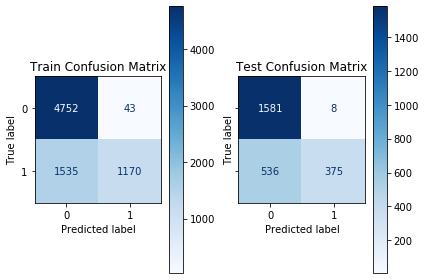

In [15]:
#Apply the modelfit function
bayesresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bayes, 'bayes')

### 3. Decision Tree Classifier

In [16]:
#Instansiate the vanilla model 
decisiontree = DecisionTreeClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4795
           1       1.00      1.00      1.00      2705

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0
Train Set Precision: 1.0
Train Set Recall: 1.0
Train Set F1-Score: 1.0


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1589
           1       0.67      0.67      0.67       911

    accuracy                           0.76      2500
   macro avg       0.74      0.74      0.74      2500
weighted avg       0.76      0.76      0.76      2500

Test Set Accuracy: 0.758
Test Set Precision: 0.666
Test Set Recall: 0.673
Test Set F1-Score: 0.67




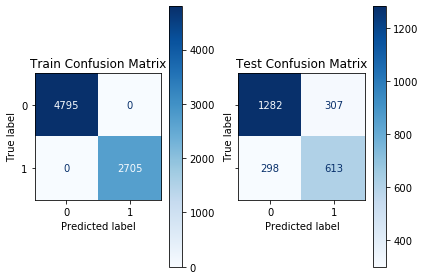

In [17]:
#Apply the model fit function 
decisiontreeresult = model_fit(X_train, y_train, X_train, y_train, X_test, y_test, decisiontree, 'decisiontree')

In [18]:
#Look at feature importances of our decision tree 
features = features_df(X_train.columns, decisiontree.feature_importances_)
features

,feature,feature_importance
0,ARRIVAL_DELAY,0.432544
1,SCHEDULED_ARRIVAL,0.078765
2,SCHEDULED_DEPARTURE,0.069750
3,SCHEDULED_TIME,0.067476
4,DISTANCE,0.066719
5,LATE_AIRCRAFT_DELAY,0.023493
6,AIRLINE_DELAY,0.022115
7,MONTH_7,0.011571
8,DAY_OF_WEEK_5,0.010587
9,AIRLINE_Southwest Airlines Co.,0.010336


The most important feature in our model is the "Arrival Delay" - this is expected, as our target variable measures the departure delay, and an arrival delay would likely follow. However, the remaining features have quite low feature importance values and with this current model, it is difficult to make any conclusions as to which features may have a stronger impact on our predictions.

### 4. Ensemble Methods

#### a. Bagging Method

In [19]:
#Instansiate the vanilla model
bagged_tree = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=20)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4795
           1       1.00      0.99      1.00      2705

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 0.997
Train Set Precision: 0.999
Train Set Recall: 0.992
Train Set F1-Score: 0.995


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1589
           1       0.77      0.64      0.70       911

    accuracy                           0.80      2500
   macro avg       0.79      0.77      0.78      2500
weighted avg       0.80      0.80      0.80      2500

Test Set Accuracy: 0.8
Test Set Precision: 0.77
Test Set Recall: 0.643
Test Set F1-Score: 0.701




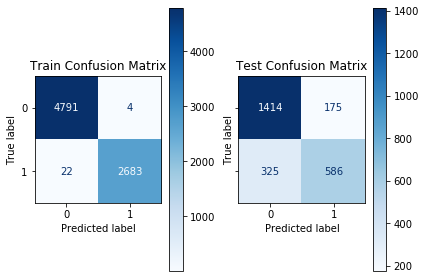

In [20]:
#Apply the model prediction
baggingresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bagged_tree, 'bagging')

#### b. Random Forest

In [21]:
#Instansiate the vanilla model 
randomforest = RandomForestClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4795
           1       1.00      1.00      1.00      2705

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0
Train Set Precision: 1.0
Train Set Recall: 1.0
Train Set F1-Score: 1.0


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1589
           1       0.79      0.63      0.70       911

    accuracy                           0.80      2500
   macro avg       0.80      0.77      0.78      2500
weighted avg       0.80      0.80      0.80      2500

Test Set Accuracy: 0.804
Test Set Precision: 0.789
Test Set Recall: 0.629
Test Set F1-Score: 0.7




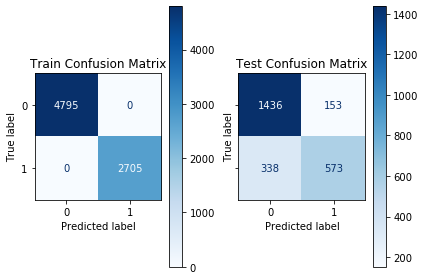

In [22]:
#Apply the model_fit function 
randomforestresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, randomforest, 'randomforest')

In [23]:
#Look at another performance measure: mean 3-Fold cross validation score 
mean_rf_cv_score = np.mean(cross_val_score(randomforest, X_train, y_train, cv=3))
mean_rf_cv_score

0.8192

### 5. Boosting

#### a. Adaboost

In [24]:
#Instansiate the vanilla model
adb = AdaBoostClassifier(random_state=0)



Train Score Results
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4795
           1       0.77      0.69      0.72      2705

    accuracy                           0.81      7500
   macro avg       0.80      0.78      0.79      7500
weighted avg       0.81      0.81      0.81      7500

Train Set Accuracy: 0.812
Train Set Precision: 0.766
Train Set Recall: 0.688
Train Set F1-Score: 0.725


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1589
           1       0.77      0.66      0.71       911

    accuracy                           0.81      2500
   macro avg       0.80      0.78      0.78      2500
weighted avg       0.80      0.81      0.80      2500

Test Set Accuracy: 0.806
Test Set Precision: 0.773
Test Set Recall: 0.664
Test Set F1-Score: 0.714




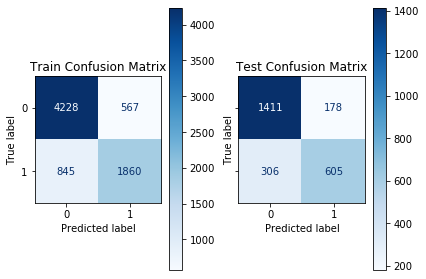

In [25]:
#Fit and predict model and show results
adbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, adb, 'Adaboost')

In [26]:
#Look at another performance measure: mean 3-Fold cross validation score 
adb_mean_cv = cross_val_score(adb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {adb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  81.22%


#### b. Gradient Boosting

In [27]:
#Instansiate the vanilla model
gb = GradientBoostingClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4795
           1       0.81      0.71      0.76      2705

    accuracy                           0.84      7500
   macro avg       0.83      0.81      0.82      7500
weighted avg       0.84      0.84      0.84      7500

Train Set Accuracy: 0.838
Train Set Precision: 0.815
Train Set Recall: 0.712
Train Set F1-Score: 0.76


Test Score Results
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1589
           1       0.80      0.68      0.74       911

    accuracy                           0.82      2500
   macro avg       0.81      0.79      0.80      2500
weighted avg       0.82      0.82      0.82      2500

Test Set Accuracy: 0.821
Test Set Precision: 0.798
Test Set Recall: 0.682
Test Set F1-Score: 0.735




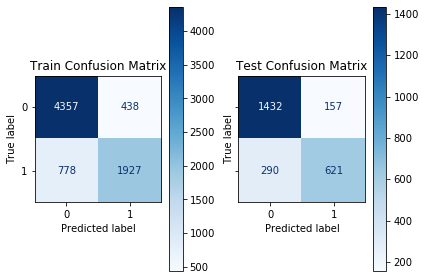

In [28]:
#Fit and predict model and show results
gbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, gb, 'Gradient_Boosting')

In [29]:
#Look at another performance measure: mean 3-Fold cross validation score 
gb_mean_cv = cross_val_score(gb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {gb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  82.34%


#### c. XGBoost

In [30]:
#Instansiate the vanilla model
xgb = XGBClassifier(random_state=0)



Train Score Results
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4795
           1       0.81      0.70      0.75      2705

    accuracy                           0.83      7500
   macro avg       0.83      0.80      0.81      7500
weighted avg       0.83      0.83      0.83      7500

Train Set Accuracy: 0.833
Train Set Precision: 0.815
Train Set Recall: 0.695
Train Set F1-Score: 0.75


Test Score Results
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1589
           1       0.80      0.67      0.73       911

    accuracy                           0.82      2500
   macro avg       0.82      0.79      0.80      2500
weighted avg       0.82      0.82      0.82      2500

Test Set Accuracy: 0.821
Test Set Precision: 0.803
Test Set Recall: 0.673
Test Set F1-Score: 0.732




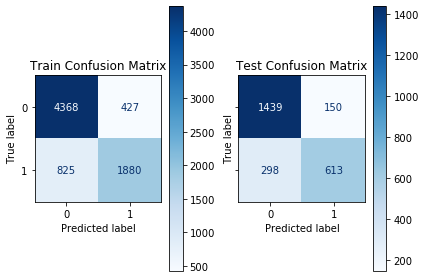

In [31]:
#Fit and predict model and show results
xgbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, xgb, 'XGBoost')

In [32]:
#Investigate XGB cross val score 
xgb_mean_cv = cross_val_score(xgb, X, y, cv=3).mean()

print(f"Mean XGboost Cross-Val Score (k=3): {xgb_mean_cv: .2%}")

Mean XGboost Cross-Val Score (k=3):  82.17%


In [33]:
#Look at feature importance for the XGBoost model 
xgb_features = features_df(X_train.columns, xgb.feature_importances_)
xgb_features

,feature,feature_importance
0,ARRIVAL_DELAY,0.138168
1,ORIGIN_AIRPORT_TYPE_High,0.073669
2,LATE_AIRCRAFT_DELAY,0.065620
3,AIRLINE_DELAY,0.063795
4,ORIGIN_AIRPORT_TYPE_Very Low,0.054443
5,DESTINATION_AIRPORT_TYPE_High,0.046067
6,AIRLINE_Southwest Airlines Co.,0.043137
7,DAY_OF_WEEK_5,0.040593
8,AIRLINE_United Air Lines Inc.,0.034651
9,AIRLINE_Delta Air Lines Inc.,0.032931


Again, arrival delay is the most important feature, however its value is lower than in our decision tree result. Interestingly, the next important feature is "Origin Airport Type - High" which represents airports with high aircraft traffic. This makes sense - if airports are experiencing a high volume of flights and are very busy, it is a) with more flights, it is more likely that some are going to be delayed and b) it could be more challenging to ensure flights are departing on time when there are limited resources at the airport itself but a high amount of flights that are departing. This feature importance value is quite low for now, but we will investigate this further when we tune our models.

### 6. Support Vector Machines

In [34]:
#Instansiate the vanilla model
svclassifier = SVC(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4795
           1       0.89      0.72      0.79      2705

    accuracy                           0.86      7500
   macro avg       0.87      0.83      0.85      7500
weighted avg       0.87      0.86      0.86      7500

Train Set Accuracy: 0.864
Train Set Precision: 0.886
Train Set Recall: 0.715
Train Set F1-Score: 0.792


Test Score Results
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1589
           1       0.77      0.58      0.66       911

    accuracy                           0.78      2500
   macro avg       0.78      0.74      0.75      2500
weighted avg       0.78      0.78      0.77      2500

Test Set Accuracy: 0.783
Test Set Precision: 0.767
Test Set Recall: 0.58
Test Set F1-Score: 0.66




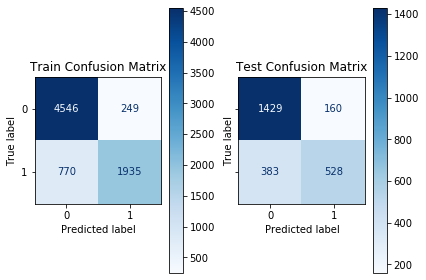

In [35]:
#Fit and predict model and show results. Note we are using the scaled data for the SVM model 
svmresult = model_fit(X_train_resampled_scaled, y_train_resampled, X_train_scaled, y_train, X_test_scaled, y_test, svclassifier, 'SVM')

### All Vanilla Results

In [36]:
#Create list of all the Vanilla model results 
result_list = [knnresult, bayesresult, decisiontreeresult, baggingresult, 
                randomforestresult, adbresult, xgbresult, svmresult]

In [37]:
#Convert results into a dataframe 
df_results = pd.DataFrame.from_dict(result_list, orient='columns')
df_results = df_results.set_index('model')

In [38]:
#Preview results 
df_results

,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,,,
knn,0.795,0.697,0.762,0.728,0.618,0.478,0.507,0.492
bayes,0.790,0.965,0.433,0.597,0.782,0.979,0.412,0.580
decisiontree,1.000,1.000,1.000,1.000,0.758,0.666,0.673,0.670
bagging,0.997,0.999,0.992,0.995,0.800,0.770,0.643,0.701
randomforest,1.000,1.000,1.000,1.000,0.804,0.789,0.629,0.700
Adaboost,0.812,0.766,0.688,0.725,0.806,0.773,0.664,0.714
XGBoost,0.833,0.815,0.695,0.750,0.821,0.803,0.673,0.732
SVM,0.864,0.886,0.715,0.792,0.783,0.767,0.580,0.660


In the context of this project's problem, we are looking to optimize recall. In the results above, the test_recall scores are highest for Decision Tree (0.671) and XGBoost (0.672). As a result, in the next section, we will tune these models to determine if we can improve these recall results even further.

Before I proceed, I will quickly look at how the vanilla models for Decision Tree and XGBoost perform when the NON SMOTE data is used. This will be used for comparison later on when comparing how the synthesized data improves the overall model results.



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4795
           1       1.00      1.00      1.00      2705

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0
Train Set Precision: 1.0
Train Set Recall: 1.0
Train Set F1-Score: 1.0


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1589
           1       0.67      0.67      0.67       911

    accuracy                           0.76      2500
   macro avg       0.74      0.74      0.74      2500
weighted avg       0.76      0.76      0.76      2500

Test Set Accuracy: 0.758
Test Set Precision: 0.666
Test Set Recall: 0.673
Test Set F1-Score: 0.67




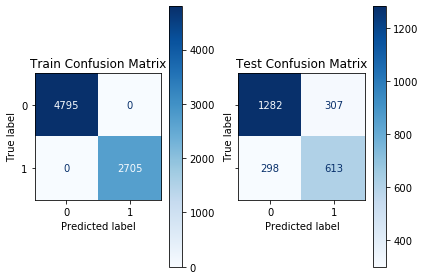

In [39]:
#Apply the model fit function to non-smoted data
decisiontreeresult_orig = model_fit(X_train, y_train, X_train, y_train, X_test, y_test, decisiontree, 'decisiontree_orig')



Train Score Results
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4795
           1       0.86      0.66      0.75      2705

    accuracy                           0.84      7500
   macro avg       0.84      0.80      0.81      7500
weighted avg       0.84      0.84      0.83      7500

Train Set Accuracy: 0.838
Train Set Precision: 0.857
Train Set Recall: 0.662
Train Set F1-Score: 0.747


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1589
           1       0.84      0.62      0.71       911

    accuracy                           0.82      2500
   macro avg       0.82      0.78      0.79      2500
weighted avg       0.82      0.82      0.81      2500

Test Set Accuracy: 0.818
Test Set Precision: 0.837
Test Set Recall: 0.623
Test Set F1-Score: 0.714




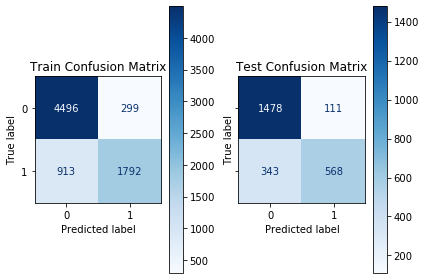

In [40]:
#Apply the model fit function to non-smoted data
xgbresult_orig = model_fit(X_train, y_train, X_train, y_train, X_test, y_test, xgb, 'XGBoost_orig')

## Section B: Tuning Models


### 1. Decision Tree

In [41]:
#Preview Decision Tree result again
decisiontreeresult

{'model': 'decisiontree',
 'train_accuracy': 1.0,
 'train_precision': 1.0,
 'train_recall': 1.0,
 'train_f1': 1.0,
 'test_accuracy': 0.758,
 'test_precision': 0.666,
 'test_recall': 0.673,
 'test_f1': 0.67}

In [42]:
#Select hyperparemeters for GridSearch to tune our decision tree model 
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 11, 15], 
    'min_samples_split': [10, 20, 30, 40], 
    'min_samples_leaf': [10, 20, 30, 40]}

gs_dt = GridSearchCV(decisiontree, param_grid, scoring='recall', cv=10)

In [43]:
#Fit the GridSearch on the resampled data
gs_dt.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 11, 15],
                         'min_samples_leaf': [10, 20, 30, 40],
                         'min_samples_split': [10, 20, 30, 40]},
             scoring='recall')

In [44]:
#Print the best Train and Test Recall scores from the GridSearch
#Print the best parameters that helped reach this result 

print(f'Train Recall: {gs_dt.best_score_}')
dttest_recall = recall_score(y_test, gs_dt.predict(X_test))
print(f'Test Recall: {dttest_recall}')
print(gs_dt.best_params_)

Train Recall: 0.8097660055671538
Test Recall: 0.7156970362239298
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 10}


By introducing hyperparameters into the model, the results improved our test recall quite a bit, from 0.67 in our vanilla model to 0.76 in our tuned model. I will now redo training, fitting and predicting the model with these best parameters.

In [45]:
#Instansiate the new model with the best parameters as given above 
dttuned = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10, 
                                 min_samples_split=10, random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      4795
           1       0.84      0.64      0.72      2705

    accuracy                           0.82      7500
   macro avg       0.83      0.78      0.80      7500
weighted avg       0.83      0.82      0.82      7500

Train Set Accuracy: 0.825
Train Set Precision: 0.84
Train Set Recall: 0.635
Train Set F1-Score: 0.724


Test Score Results
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1589
           1       0.83      0.61      0.70       911

    accuracy                           0.81      2500
   macro avg       0.82      0.77      0.78      2500
weighted avg       0.81      0.81      0.80      2500

Test Set Accuracy: 0.811
Test Set Precision: 0.829
Test Set Recall: 0.607
Test Set F1-Score: 0.701




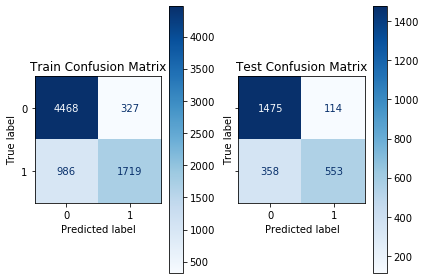

In [46]:
#Fit and predict model and show results
dttunedresult = model_fit(X_train, y_train, X_train, y_train, X_test, y_test, dttuned, 'Decision Tree Tuned')

In [47]:
#Look at feature importance for the tuned decision tree  
overall_features = features_df(X_train.columns, dttuned.feature_importances_)
overall_features

,feature,feature_importance
0,ARRIVAL_DELAY,0.748387
1,LATE_AIRCRAFT_DELAY,0.094194
2,AIRLINE_DELAY,0.061741
3,SCHEDULED_TIME,0.033721
4,SCHEDULED_DEPARTURE,0.013259
5,AIRLINE_United Air Lines Inc.,0.012403
6,DISTANCE,0.009914
7,WEATHER_DELAY,0.008912
8,AIR_SYSTEM_DELAY,0.006253
9,AIRLINE_Southwest Airlines Co.,0.006188


Many of the features have a feature importance of 0 in our decision tree. Before we plot the features on a graph, I will filter out the values that have 0 so we can have a cleaner visual as to which features are important in the results of our decision tree.

In [48]:
#Create new dataframe of all non-zero features 
overall_features_2 = overall_features[overall_features['feature_importance']>0]

In [49]:
#Print the. dataframe
overall_features_2

,feature,feature_importance
0,ARRIVAL_DELAY,0.748387
1,LATE_AIRCRAFT_DELAY,0.094194
2,AIRLINE_DELAY,0.061741
3,SCHEDULED_TIME,0.033721
4,SCHEDULED_DEPARTURE,0.013259
5,AIRLINE_United Air Lines Inc.,0.012403
6,DISTANCE,0.009914
7,WEATHER_DELAY,0.008912
8,AIR_SYSTEM_DELAY,0.006253
9,AIRLINE_Southwest Airlines Co.,0.006188


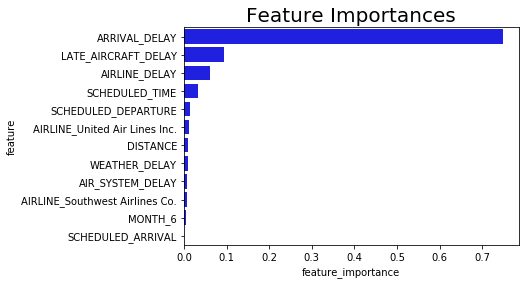

In [50]:
#Plot the feature importances 
features_plot(overall_features_2, 'Feature Importances')

The top 3 features in the plot above are particularly noteworthy; arrival delay, late aircraft delay, and airline delay are the more important features in this model. Unsurprisingly, an arrival delay would be important when classifying a departure delay. Next, the top two features that are useful in our predictive analysis are late aircraft delays and airline delays. We also see that of all the airlines, United Air Lines is the highest feature of importance in the model. This concludes that while issues with weather, security, and airport delays could be highly influential in determining a departure delay, our model indicates that late aircrafts and airline delays are of higher importance in our model.

### 2. XGBoost

In [51]:
#Preview XGBoost results again 
xgbresult

{'model': 'XGBoost',
 'train_accuracy': 0.833,
 'train_precision': 0.815,
 'train_recall': 0.695,
 'train_f1': 0.75,
 'test_accuracy': 0.821,
 'test_precision': 0.803,
 'test_recall': 0.673,
 'test_f1': 0.732}

In [52]:
#Build parameter grid to be used in GridSearch to find the best hyperparameters
param_grid = {
    'max_depth': [1, 5, 8],
    'learning_rate': [.1, .15, 1], 
    'subsample': [.5, .9],
    'min_split_loss': [1, 3, 5],
    'n_estimators': [100, 500, 1000]
}
gs_xgb = GridSearchCV(xgb, param_grid, scoring='recall', cv=3)



In [53]:
# Fit the gridsearched with our X and Y resampled data 
gs_xgb.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.15, 1],
                         'max_depth': [1, 5, 8], 'min_split_loss': [1, 3, 5],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.5, 0.9]},
             scoring='recall')

In [54]:
#Display the best possible recall results as well as the best parameters
print(f'Train Recall: {gs_xgb.best_score_}')
xgbtest_recall = recall_score(y_test, gs_xgb.predict(X_test))
print(f'Test Recall: {xgbtest_recall}')
print(gs_xgb.best_params_)

Train Recall: 0.8020898804347628
Test Recall: 0.6750823271130626
{'learning_rate': 1, 'max_depth': 8, 'min_split_loss': 3, 'n_estimators': 1000, 'subsample': 0.9}


In [55]:
#Look at another performance measure: mean 3-Fold cross validation score 
xgb_mean_cv = cross_val_score(xgb, X, y, cv=3).mean()

print(f"Mean XGboost Cross-Val Score (k=3): {xgb_mean_cv: .2%}")

Mean XGboost Cross-Val Score (k=3):  82.17%


In [56]:
#Instansiate an XGB model with the best parameters as indicated above
xgbtuned = XGBClassifier(learning_rate=1, max_depth=5, 
                         min_split_loss=1, n_estimators=1000, subsample=0.9)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4795
           1       1.00      1.00      1.00      2705

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0
Train Set Precision: 1.0
Train Set Recall: 1.0
Train Set F1-Score: 1.0


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1589
           1       0.73      0.67      0.70       911

    accuracy                           0.79      2500
   macro avg       0.77      0.76      0.77      2500
weighted avg       0.79      0.79      0.79      2500

Test Set Accuracy: 0.79
Test Set Precision: 0.731
Test Set Recall: 0.67
Test Set F1-Score: 0.699




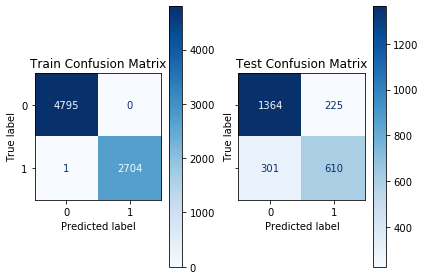

In [57]:
#Apply the model fit function to the tuned XGB Classifier
xgbtunedresult = model_fit(X_train, y_train, X_train, y_train, X_test, y_test, xgbtuned, 'XGBoost Tuned')

In [58]:
#Look at feature importance for the decision tree for the tuned model
xgbtuned_features = features_df(X_train.columns, xgbtuned.feature_importances_)
xgbtuned_features

,feature,feature_importance
0,LATE_AIRCRAFT_DELAY,0.213489
1,AIRLINE_DELAY,0.130776
2,WEATHER_DELAY,0.073675
3,ARRIVAL_DELAY,0.052334
4,AIRLINE_Hawaiian Airlines Inc.,0.027369
5,AIRLINE_United Air Lines Inc.,0.023610
6,AIRLINE_Southwest Airlines Co.,0.019214
7,AIR_SYSTEM_DELAY,0.018864
8,MONTH_6,0.015491
9,AIRLINE_US Airways Inc.,0.014410


Similar to the decision tree tuned model, "Late Aircraft Delay" and "Airline Delay" are the top feature importances. Here, however, "Arrival Delay" is not as high of importance. Again we see that United Air Lines has higher importance than other airlines, however the value for this is quite low, at 0.054.

## Conclusion and Recommendations

In order to interpret the results, it is crucial that we compare both the train and test results from the tuned models to the results from the vanilla models. I will build a DataFrame that shows these results side by side so that the interpretation is as reader-friendly as possible. 

In [59]:
#Create list of results for vanilla and tuned models for Decision Trees and XGBoost 
result_list_updated = [decisiontreeresult, dttunedresult, xgbresult, xgbtunedresult]

In [60]:
#Convert results into a dataframe
df_results_updated = pd.DataFrame.from_dict(result_list_updated, orient='columns')
df_results_updated = df_results_updated.set_index('model')

In [61]:
#Print the DataFrame 
df_results_updated

,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,,,
decisiontree,1.000,1.000,1.000,1.000,0.758,0.666,0.673,0.670
Decision Tree Tuned,0.825,0.840,0.635,0.724,0.811,0.829,0.607,0.701
XGBoost,0.833,0.815,0.695,0.750,0.821,0.803,0.673,0.732
XGBoost Tuned,1.000,1.000,1.000,1.000,0.790,0.731,0.670,0.699


In the context of our model, we are looking to prioritize the recall of the model, and we do so by looking at the test set score results. When we prioritize recall, we are allowing for more false positives than false negatives; i.e., we are ensuring that we do not "miss" classifying any delayed flights incorrectly, so that all the values in the dataset that are delayed will be classified as delayed. This could introduce additional false positives in our model, but by maximizing recall we are minimizing false negatives, which is appropriate in our context. This is important as the FAA would like to be particularly careful when determining which flights are actually delayed so that their resources can be effectively distributed to necessary airlines and/or airports in order to maximize efficiency of the United States flights system. 

First, we looked at the decision tree model. Our vanilla decision tree model is overfit to our training data, as seen by perfect metric scores of 1 across all performance metrics for the train set, but this does not appear to be the case once our model has been tuned. The test recall score improved from 0.671 to 0.739 after tuning. There were slight increases in test accuracy, precision and f1 scores as well, although much smaller relative increases than the recall score. Additionally, our tuned decision tree's top feature importances were "Arrival Delay", "Late Aircraft Delay" and "Airline Delay". Our recommendation to the FAA is to invest in resources to mitigate these specific types of delays, as they are the most powerful in predicting whether a flight is delayed or not. While it does not appear that a specific airline has a higher impact in predicting a delayed flight over another, more research should be allocated to identify the specific factors that cause an "Airline Delay" in order to prevent these delays going forward. When looking at the train and test confusion matrices for our decision tree model, overall, our model does a fairly good job at correctly classifying our results. 

Next, we looked a the XGBoost model, whose test recall score only improved slightly after tuning. We also see a decrease in all the remaining test results; accuracy, precision and f1, therefore an increase in recall came at the expense of the other performance metrics. Interestingly, all of our train metrics in our tuned model had a result of 1; indicating that our model is overfit to our training data. Future work should look at altering the hyperparameters in the GridSearch in order to prevent overfitting, as well as optimize our XGBoost Tuned test recall further. Regardless, the feature importances of our XGBoost Tuned model do align with the decision tree results; "Late Aircraft Delay" and "Airline Delay" are both the highest feature importances for our model and prove to be strongly influential in predicting our classification results. 

In conclusion, we believe that the Decision Tree tuned model is the best at classifying our target variable, Departure Delay. Our final model does not appear to be overfit, and all of the test set performance metrics improved to some extent, most notably test_recall which is the element we are aiming to prioritize in the context of our business problem. As a result, the FAA should consider using this ML model when classifying future data points. Additionally, the FAA, along with the help of our team of strategists, will look into how resources can be reallocated in order to prevent delays particularly due to airline delays and late aircraft delays.

### Future Work

There are several additional items that could be considered in future work: 

- Additional data cleaning: such as removing outliers, removing variables that are not highly correlated with the target variable. These techniques could be implemented before we process our models to see if there is an impact on the results.
- After plotting the feature importance graph for both Decision Tree Classifier and XGBoost models, we could drop features of low importance (especially those with feature importance of 0). Then, I would rerun models to see how/if the results are any different once these features are removed. 
- Including more hyperparameters and further tuning of the model could potentially increase the test recall scores ever further. This is particularly relevant for XGBoost whose test recall score only improved slightly after the hyperparmeters were tuned. In particular, certain additional hyperparemeters could be included, such as "colsample_by" to subset columns either by tree, level or node, or "sampling_method" to introduce a non-uniform method to sample the training instances. In addition, I could introduce new values to the hyperparameters that were already included in our original GridSearch to see if these different values are able to increase the test recall score even higher.
- Looking into other models, such as RandomForest Classifier and ADBoost, could be alternative methods of trees and boosting algorithms that, after tuning, could produce even stronger test recall scores than what was found by tuning the decision tree and XGBoost classifiers.
- Lastly, it is important to remember that this entire analysis was done on a random subset of 10,000 rows of data. Future work could look to take a different random sample of 10,000 from the initial dataset and compare those results to the results that were found above. Additionally, with more time, a similar analysis could be conducted on the entire dataset to determine if our results will differ. 